In [12]:
#split train and test data
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

cwd = os.getcwd()
df = pd.read_csv(cwd + "/data_csv/preprocessing_data.csv")

train, test = train_test_split(df, test_size=0.1)


In [13]:
train = pd.DataFrame(train, columns=["image", "emotion"])
dictionary = {'emotion':{'HAPPINESS': 0,'NEUTRAL': 1, 'SURPRISE': 2, 'ANGER': 3, 'SADNESS': 4, 'DISGUST': 5}}
train.replace(dictionary, inplace = True)
train.to_csv(cwd + "/data_csv/train.csv")

train.groupby('emotion').count()

,image
emotion,
0,2113
1,2017
2,80
3,69
4,35
5,6


In [14]:
test = pd.DataFrame(test, columns=["image", "emotion"])
dictionary = {'emotion':{'HAPPINESS': 0,'NEUTRAL': 1, 'SURPRISE': 2, 'ANGER': 3, 'SADNESS': 4, 'DISGUST': 5}}
test.replace(dictionary, inplace = True)
test.to_csv(cwd + "/data_csv/test.csv")

test.groupby('emotion').count()

,image
emotion,
0,246
1,219
2,6
3,9
4,1


In [17]:
df = train

In [18]:
import cv2, math, numpy as np, dlib
from imutils import face_utils

# emotion list
emotions = [0, 1, 2, 3, 4, 5] 
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(cwd + "/predictor/shape_predictor_68_face_landmarks.dat")

error = 0

mlist = []
distlist = []
# run each image in train
for idx, row in df.iterrows():
    imagePath = cwd + "/cleaned_images/" + row.image
    image = cv2.imread(imagePath)

    rects = detector(image, 0)

    if len(rects) == 0:
        error += 1
        print(row.image)

    xlist = []
    ylist = []
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks and convert the facial landmark (x, y)
        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over coordinates, draw them on the image and store coordinates in two lists
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            cv2.imshow("Output", image)
            xlist.append(x)
            ylist.append(y)

    # get mean of both axes to determine centre of gravity
    xmean = np.mean(xlist) 
    ymean = np.mean(ylist)

    # plot central face on image
    cv2.circle(image, (int(xmean), int(ymean)), 1, (0, 255, 0), -1)

    # find distance between mouth
    mavg = np.mean([ylist[61] - ylist[67], ylist[62] - ylist[66], ylist[63] - ylist[65]])
    mlist.append(mavg)

    # find distance between every poin to central point
    templist = []
    for i in range(17, 68):
        dist = math.sqrt(math.pow(xlist[i] - xmean, 2) + math.pow(ylist[i] - ymean, 2))
        templist.append(dist)
    distavg = np.mean(dist)
    distlist.append(distavg)
  
    # show the output image with the face detections + facial landmarks
    # cv2.imshow("Output", image)# 
    # k = cv2.waitKey(5) & 0xFF
    # if k == 68:
        # break

print(error)

0


In [19]:
df['mouth_distance'] = mlist
df['average_distance'] = distlist

df.to_csv(cwd + "/data_csv/train.csv")

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

X = df[df.columns.difference(['emotion', 'image'])]
y = df.loc[:,'emotion']

print(X.shape, y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4320, 2) (4320,)


In [32]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

clf = svm.SVC(kernel='poly', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
print(clf.score(X_val, y_val))

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_val, y_val))

rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
print(rf.score(X_val, y_val))

0.7060185185185185
0.6967592592592593
0.7013888888888888
0.7060185185185185
0.6388888888888888


C:\Users\omsin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      average_distance  mouth_distance
794          55.644426       -3.666667
4255         84.572573      -35.333333
819          64.547926       -4.666667
198          64.137618       -0.666667
4777         86.308396      -27.000000
...                ...             ...
20           65.962722        0.666667
3391         74.219353      -30.666667
161          73.552755      -18.666667
2083         69.577639      -18.666667
2042         81.844836      -13.333333

[4320 rows x 2 columns] 794     0
4255    0
819     1
198     1
4777    0
       ..
20      1
3391    0
161     1
2083    0
2042    0
Name: emotion, Length: 4320, dtype: int64


KeyError: "None of [Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,\n            ...\n            3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887],\n           dtype='int64', length=3887)] are in the [columns]"

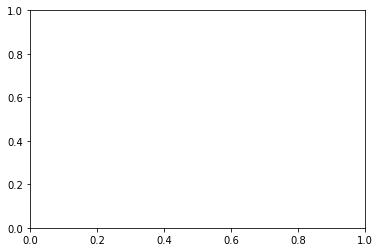

In [70]:
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt

score_lr = []
score_svm_l = []
score_svm_p = []
score_svm_r = []
score_rf = []

X = df[df.columns.difference(['emotion', 'image'])]
y = df.loc[:,'emotion']

print(X, y)

random_state = np.random.RandomState(0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)

cv = StratifiedGroupKFold(n_splits=5, shuffle=True)

history = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X[train], X[val]
    